# Funnel metadynamics result analysis examples

The main purpose of funnel metadynamics (fun-metaD) is to obtain an absolute binding free energy estimate. By depositing bias along the two CVs, you can acquire reconstruct a free energy surface (FES), which, if the ligand is a real binder, will show a deep valley at the protein end of the funnel and a plateau at the solvent end. By finding a difference between the the two, you get the estimated binding free energy. Now you need to account for the lost of translational entropy (due to the funnel restraints), as described in the Computational Methods of [Rhys *et al* 2020](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7467642/).

In this NB I will give you some examples of what analysis of fun-metaD simulations look like, first for the PLUMED version (Part 1), then for the OpenMM implementation (Part 2). The reason for showing examples of my scripts instead of something more packaged, is the fact that each person will need something different from their data, so I'll show examples for people to draw ideas from.

To preserve space, I won't give all of the FES file along with this NB, so **don't run the cells**.

In [4]:
import numpy as np
import shutil
import os
import matplotlib.pyplot as plt
import pandas as pd
import subprocess as sp
import glob

from math import exp, log
import scipy.stats
from collections import deque

## Part 1 - PLUMED implementation analysis

In [5]:
# finds the relative free energy of a 1D FES, usually
# of the proj CV
# you will see where this is used in the cell below
def fes_rel(fes_list, fes_all=None, kT=2.49):
    results = []
    for i in fes_list:
        temp = 0
        for j in i:
            temp += exp(-j / kT)
        results.append(temp)
    total = 0
    if fes_all is None:
        for i in results:
            total += i
    else:
        for i in fes_all:
            total += i
            
    results_2 = []
    for i in results:
        if i > 0:
            results_2.append(-kT * log(i / total))
        else:
            results_2.append(np.inf)
    min_res = min(results_2)
    return [i - min_res for i in results_2]

In [6]:
# if you have experimental data to compare your 
# results to...
base_dir = '.'

exp_dict = {'3U5J': -7.65, '3U5L': -8.45, '4HBV': -6.33, '4LR6': -6.11, '4MEQ': -4.91, '4PCI': -6.99,
            '4UYD': -5.59}

As a measure of good exploration of the FES and convergence is the plotting of the two CVs vs time.

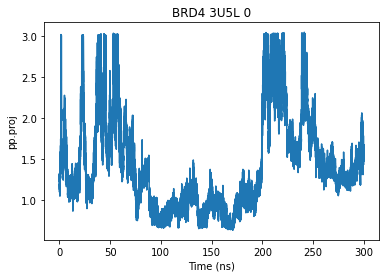

/home/dom/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


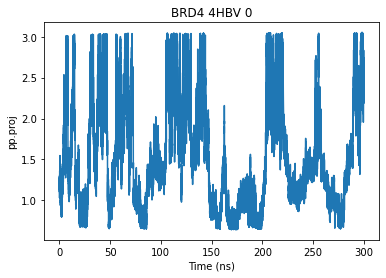

/home/dom/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


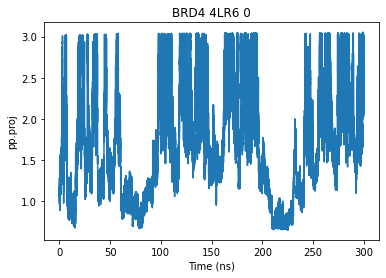

/home/dom/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


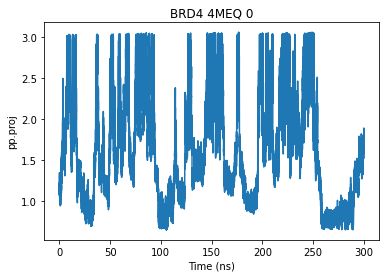

/home/dom/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


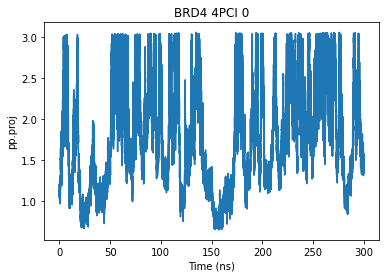

/home/dom/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


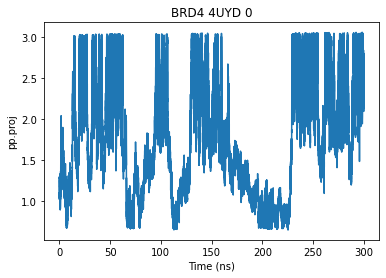

/home/dom/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


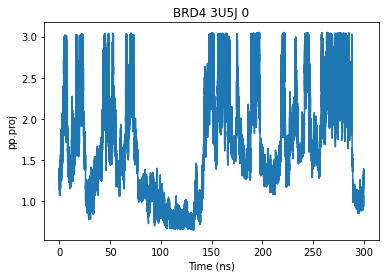

In [29]:
# CVs vs time
base_dir = '/home/dom/Projects/dev_funnel/funnel_assignment/tutorial/'
analysis_dir =  '%s/analysis'% base_dir
system = 'BRD4'
fragment_pdb_list = ['3U5L','4HBV','4LR6','4MEQ','4PCI','4UYD','3U5J']
            
for pdb_id in fragment_pdb_list:

    for i in range(0, 1):

        cwd = '%s/%s/%i_output/%s'% (analysis_dir,system,i,pdb_id)

        os.chdir(cwd)

        df = pd.read_csv('HILLS', delim_whitespace=True).iloc[1:,:-2]

        df.columns = ['time','pp.proj','pp.ext','sigma_pp.proj','sigma_pp.ext','height','biasf']

        # Drop via logic: similar to SQL 'WHERE' clause
        df = df[df.time != '#!']

        df = df.apply(pd.to_numeric)

        plt.title('%s %s %i'% (system, pdb_id, i))
        plt.plot(df.time/1000,df['pp.proj'])

        # if plotting height of Gaussians, use a log scale
#                 plt.scatter(x = df.time/1000, y = df['height'], c = 'crimson')

#                 plt.yscale('log')
#                 plt.ylim(0.001, 10)
        plt.xlabel('Time (ns)')
        plt.ylabel('pp.proj')
        plt.show()

In [ ]:
# prepare the FES, 1D and 2D
system = 'BRD4':
fragment_pdb_list = ['3U5L','4HBV','4LR6','4MEQ','4PCI','4UYD','3U5J']

for i in range(0,3):

    for pdb_id in fragment_pdb_list:

        cwd = '%s/%s/%i_output/%s'% (base_dir,system,i,pdb_id)
        os.chdir(cwd)

        # 1D
        if not os.path.isfile('fes_1d.dat29.dat'):
            if os.path.isfile('fes_1d.dat0.dat'):
                for file in glob.glob('fes_1d.dat*'):
                    os.remove(file)
            # writes a 1D FES file every 10ns, integrating out the pp.ext CV
            sp.call('plumed sum_hills --hills HILLS --idw pp.proj --kt 2.49 --outfile fes_1d.dat --stride 5000'\
                    ,shell=True)
        # 2D
        if not os.path.isfile('fes.dat29.dat'):
            if os.path.isfile('fes.dat0.dat'):
                for file in glob.glob('fes.dat*'):
                    os.remove(file)
            # writes a 2D FES file every 10ns
            sp.call('plumed sum_hills --hills HILLS --kt 2.49 --outfile fes.dat --stride 5000',\
                    shell=True)

/home/dom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


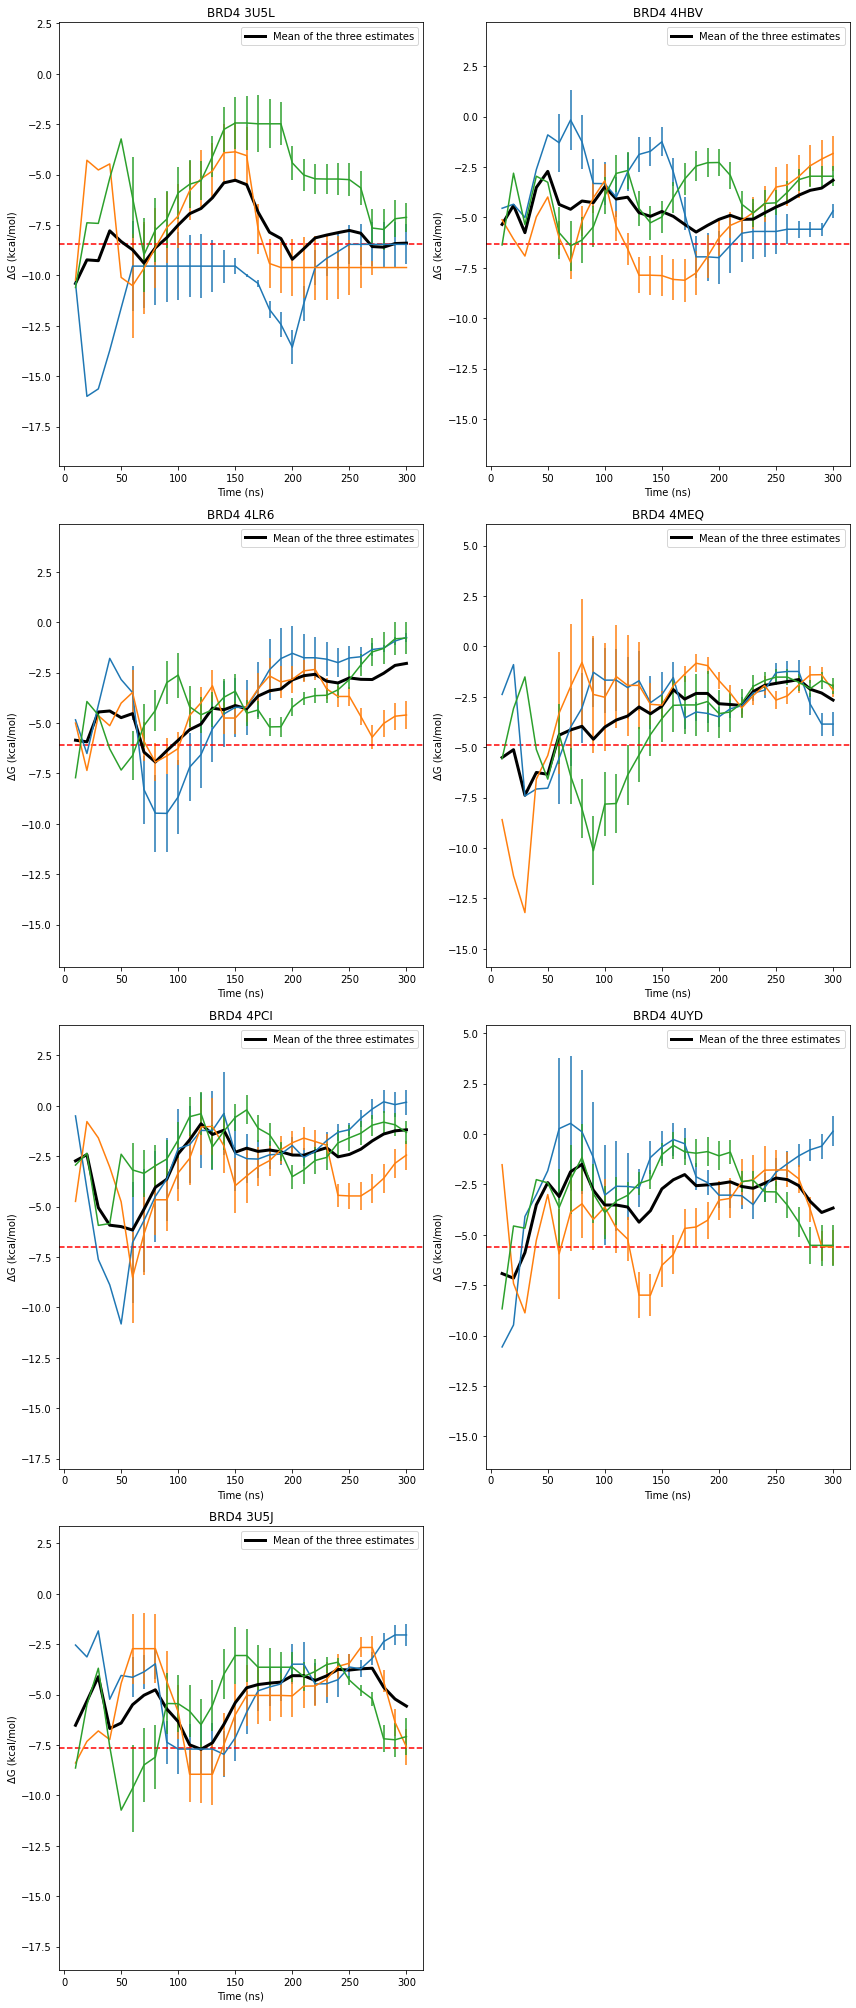

In [15]:
# plot dG vs time

base_dir = '/home/dom/Projects/dev_funnel/funnel_assignment/tutorial/analysis/'

system = 'BRD4'
fragment_pdb_list = ['3U5L','4HBV','4LR6','4MEQ','4PCI','4UYD','3U5J']
funnel_correction = 2.45
   
plot_index = 1
f = plt.figure(figsize=(12,len(fragment_pdb_list)*4))

for pdb_id in fragment_pdb_list:
    ax = f.add_subplot(int(len(fragment_pdb_list)/2)+1, 2, plot_index)
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('ΔG (kcal/mol)')
    ax.axhline(y = exp_dict[pdb_id], color = 'red', linestyle = '--')

    estimates_lists = deque()

    for i in range(0,3):

        cwd = '%s/%s/%i_output/%s'% (base_dir,system,i,pdb_id)

        os.chdir(cwd)

        ns = []
        estimates = []
        oscillations = []
        start_from_idx = 5

        for n in range(0, len(glob.glob('fes_1d.dat*'))):

            fes_data = np.loadtxt('fes_1d.dat%i.dat'% ( n))

            fes_1d = fes_rel(fes_data)
            estimate = -(np.median(fes_1d[-65:-15])/4.184 - funnel_correction)

            ns.append((n + 1)*10)
            estimates.append(estimate.round(2))

            # add oscillations
            if n < start_from_idx:
                oscillations.append(0)
            else:
                if n < 10:
                    oscillation = scipy.stats.sem(estimates[:])
                else:
                    oscillation = scipy.stats.sem(estimates[n-10:])
                # 2x as it is the difference between two estimates, bound and unbound
                oscillations.append(oscillation*2) 

        plt.errorbar(ns, estimates, yerr=oscillations)#, color='darkorange', ecolor = 'orange')

        estimates_lists.append(estimates)

    mean_estimates = []
    # in case some sims haven't yet finished
    shortest_list = min([ len(item) for item in estimates_lists])

    for index in range(shortest_list):
        tmp_list = []
        for l in range(len(estimates_lists)):
            tmp_list.append(estimates_lists[l][index])
        mean_estimates.append(np.mean(tmp_list).round(2))

    plt.plot(ns[:len(mean_estimates)], mean_estimates, color = 'black', linewidth = 3,\
             label = 'Mean of the three estimates')
    plt.ylim(exp_dict[pdb_id] - 11, exp_dict[pdb_id] + 11)
    plt.legend()
    plt.title('%s %s'% (system, pdb_id))

    plot_index += 1

f.tight_layout()
f.show()

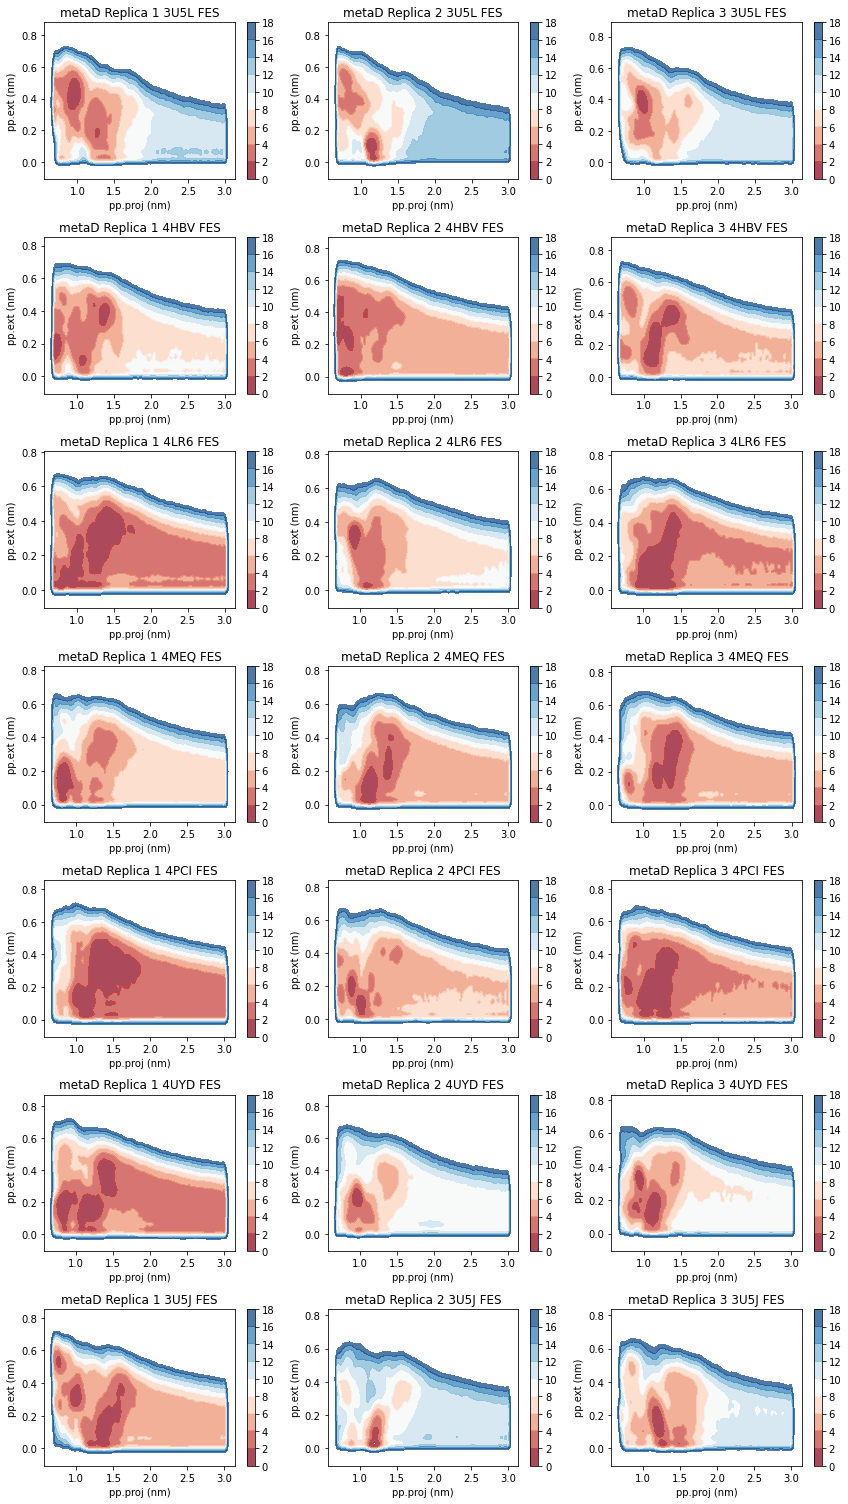

In [16]:
########### PLOTTING 2D FES ##############

base_dir = '/home/dom/Projects/dev_funnel/funnel_assignment/tutorial/analysis/'

system = 'BRD4'
fragment_pdb_list = ['3U5L','4HBV','4LR6','4MEQ','4PCI','4UYD','3U5J']
funnel_correction = 2.45
            
plot_index = 1

f = plt.figure(figsize=(12,len(fragment_pdb_list)*3))

for pdb_id in fragment_pdb_list:

    for i in range(0, 3):

        cwd = '%s/%s/%i_output/%s'% (base_dir,system,i,pdb_id)

        os.chdir(cwd)

        fes=np.loadtxt('fes.dat29.dat')

        x=fes[:,0]
        y=fes[:,1]
        z=fes[:,2]/4.168

        N=200
        xi = np.linspace(x.min(), x.max(), N*2)
        yi = np.linspace(y.min(),y.max(), N)
        zi = scipy.interpolate.griddata((x, y), (z-z.min()), (xi[None,:], yi[:,None]), method='cubic')

        cmap='RdBu'

        ax = f.add_subplot(len(fragment_pdb_list), 3, plot_index)

        ax.set_title('%s Replica %i %s FES' % (method, i+1, pdb_id))

        ax.set_ylabel('pp.ext (nm)')
        ax.set_xlabel('pp.proj (nm)')

        plt.contourf(xi, yi, zi, np.arange(0, 20, 2), cmap=cmap, alpha=.75)
        plt.colorbar()

        plot_index += 1

f.tight_layout()

-8.46
-9.61
-7.12
3U5L dG = -8.39 kcal/mol +- 1.02, error 0.06 kcal

-4.68
-1.83
-2.96
4HBV dG = -3.16 kcal/mol +- 1.17, error 3.17 kcal

-0.75
-4.60
-0.78
4LR6 dG = -2.04 kcal/mol +- 1.81, error 4.07 kcal

-3.85
-2.17
-1.96
4MEQ dG = -2.66 kcal/mol +- 0.85, error 2.25 kcal

0.18
-2.44
-1.32
4PCI dG = -1.19 kcal/mol +- 1.07, error 5.80 kcal

0.14
-5.62
-5.52
4UYD dG = -3.67 kcal/mol +- 2.69, error 1.92 kcal

-2.04
-7.60
-7.08
3U5J dG = -5.57 kcal/mol +- 2.51, error 2.08 kcal


y=0.816640x+1.556605



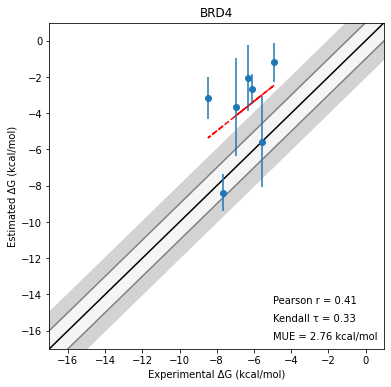

In [17]:
# expt vs estimated

########################
## plotting functions ##
########################

def draw_expt_calc_plot(system, start, end):
    
    if system == 'BRD4':
        fragment_pdb_list = ['3U5L','4HBV','4LR6','4MEQ','4PCI','4UYD','3U5J']
        funnel_correction = 2.45

    base_dir = '/home/dom/Projects/dev_funnel/funnel_assignment/tutorial/analysis/'

    exp_dict = {'3U5J': -7.65, '3U5L': -8.45, '4HBV': -6.33, '4LR6': -6.11, '4MEQ': -4.91, '4PCI': -6.99,
                '4UYD': -5.59}
    estimate_dict = {}
    stdiv_list = []
    error_list = []

    for pdb_id in fragment_pdb_list:
        tmp_estimate_list = []
        
        for i in range(start, end):
            
            cwd = '%s/%s/%i_output/%s'% (base_dir,system,i,pdb_id)
            
            if os.path.isfile('%s/fes_1d.dat29.dat'% cwd):
                fes_data = np.loadtxt('%s/fes_1d.dat29.dat'% cwd)
            else:
                fes_data = np.loadtxt('%s/fes_1d.dat0.dat'% cwd)
            fes_1d = fes_rel(fes_data)
            estimate = -(np.median(fes_1d[-65:-15])/4.184 - funnel_correction)
            

            print('%.2f' % estimate)
            tmp_estimate_list.append(estimate)
        mean_estimate = np.mean(tmp_estimate_list)
        estimate_dict[pdb_id] = mean_estimate

        stdiv = np.std(tmp_estimate_list)
        stdiv_list.append(stdiv)

        error = abs(exp_dict[pdb_id]-mean_estimate)
        error_list.append(error)
        print('%s dG = %.2f kcal/mol +- %.2f, error %.2f kcal\n'%(pdb_id, mean_estimate, stdiv, error))


    exp_list = []
    for k,v in exp_dict.items():
        if k in fragment_pdb_list:
            exp_list.append(v)

    est_list = []
    for k,v in estimate_dict.items():
        est_list.append(v)

    # Lets make a plot now
    
    plt.figure(figsize = (6, 6))
    
    # 2 kcal 'up'
    plt.plot([-26,26],[-24,28],'lightgrey')
    # 1 kcal 'up'
    plt.plot([-26,26],[-25,27],'grey')
    # main trendline y = x
    plt.plot([-26,26],[-26,26],'k-')
    # 1 kcal 'down'
    plt.plot([-26,26],[-27,25],'grey')
    # 2 kcal/down
    plt.plot([-26,26],[-28,24],'lightgrey')

    # light grey for 1 kcal band
    plt.fill_between([-26,26], [-26,26], [-27,25],facecolor='whitesmoke')
    plt.fill_between([-26,26], [-26,26], [-25,27],facecolor='whitesmoke')

    # darker grey for 2 kcal band
    plt.fill_between([-26,26], [-27,25], [-28,24],facecolor='lightgrey')
    plt.fill_between([-26,26], [-25,27], [-24,28],facecolor='lightgrey')


    plt.xlabel('Experimental ΔG (kcal/mol)')
    plt.ylabel('Estimated ΔG (kcal/mol)')

    plt.title('%s'% (system))
    plt.scatter(exp_list, est_list, zorder = 20)
    plt.errorbar(exp_list, est_list, yerr = stdiv_list, linestyle="None", zorder = 15)
    plt.text(-5, -14.5, s = 'Pearson r = %.2f'% scipy.stats.pearsonr(exp_list,est_list)[0])
    plt.text(-5, -15.5, s = 'Kendall τ = %.2f'% scipy.stats.kendalltau(exp_list,est_list)[0])
    plt.text(-5, -16.5, s = 'MUE = %.2f kcal/mol'% np.mean(error_list))

    xmin, xmax = -17, 1
    plt.xlim(xmin, xmax)

    ymin, ymax = -17, 1
    plt.ylim(ymin, ymax)

    # calc the trendline
    z = np.polyfit(exp_list, est_list, 1)
    p = np.poly1d(z)
    plt.plot(exp_list, p(exp_list), "r--")
    
    # the line equation:
    print("\ny=%.6fx+%.6f\n"%(z[0],z[1]))


draw_expt_calc_plot('BRD4', 0, 3)

In [ ]:
# prepare vmd scripts

base_dir = '/home/dom/Projects/dev_funnel/funnel_assignment/tutorial/analysis/'
fragment_pdb_list = ['3U5L','4HBV','4LR6','4MEQ','4PCI','4UYD','3U5J']
system = 'BRD4'

for i in range(0,3):

    for pdb_id in fragment_pdb_list:
        os.chdir('%s/%s/%i_output/%s'% (base_dir,system,method,i,pdb_id))

        with open('vmd_script.tcl','w') as SCRIPT:
            # NOTE - amber file format, will be different for gromacs
            SCRIPT.write('mol load parm7 solvatedHMR.prmtop\n')
            SCRIPT.write('mol modselect 0 0 all not water\n')
            SCRIPT.write('mol modstyle 0 0 NewCartoon\n')
            SCRIPT.write('mol addrep 0\n')
            SCRIPT.write('mol modselect 1 0 resname MOL\n')
            SCRIPT.write('mol modstyle 1 0 Licorice\n')
            SCRIPT.write('mol addrep 0\n')
            SCRIPT.write('mol modselect 2 0 protein within 7 of resname MOL\n')
            SCRIPT.write('mol modstyle 2 0 Lines\n')
            SCRIPT.write('mol addfile prod/mdcrd type netcdf step 2\n')

## Part 2 - OpenMM fun-metaD analysis

/home/dom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


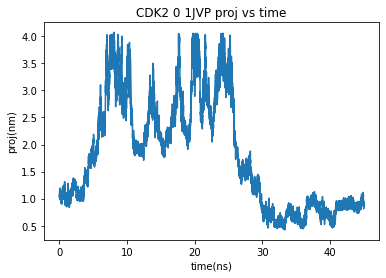

/home/dom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


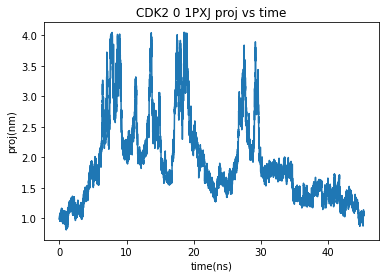

/home/dom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


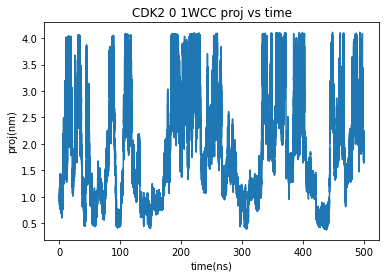

/home/dom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


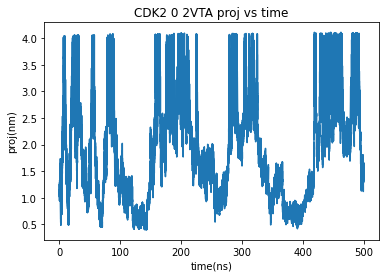

/home/dom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


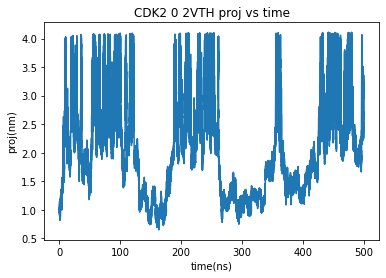

/home/dom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


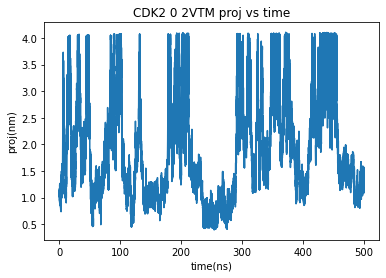

/home/dom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


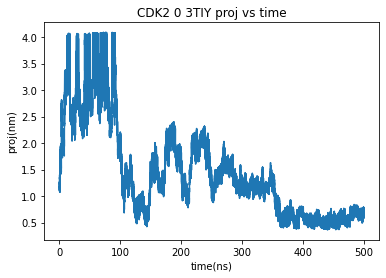

/home/dom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


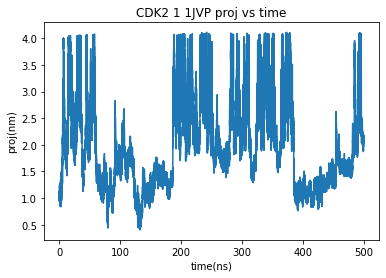

/home/dom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


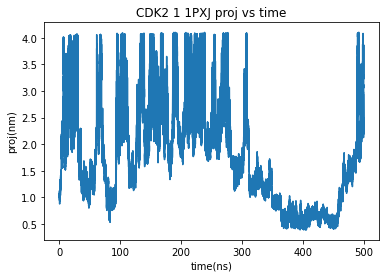

/home/dom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


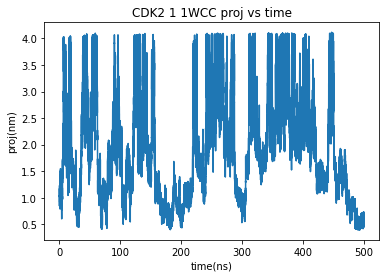

/home/dom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


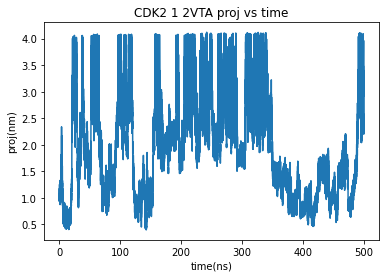

/home/dom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


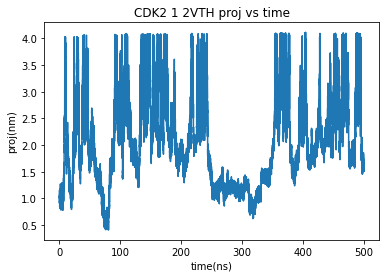

/home/dom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


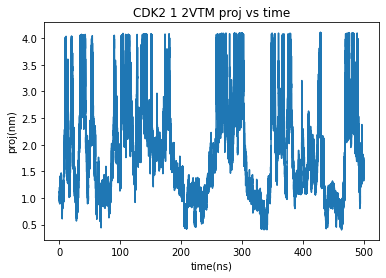

/home/dom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


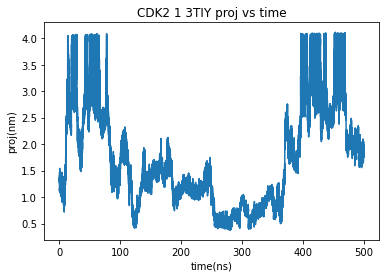

/home/dom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


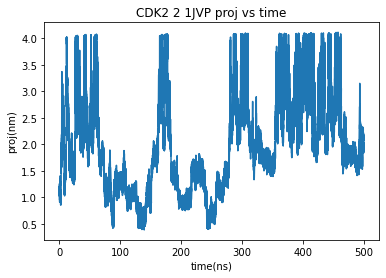

/home/dom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


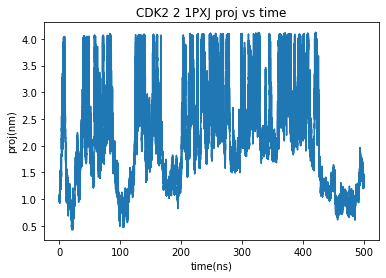

/home/dom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


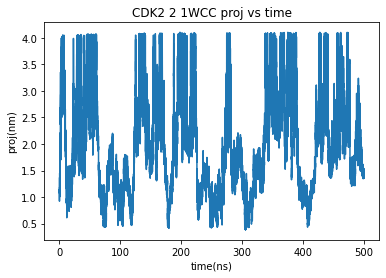

/home/dom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


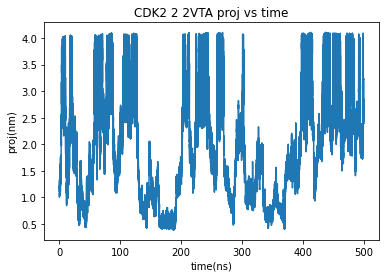

/home/dom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


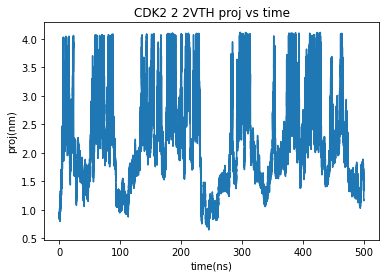

/home/dom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


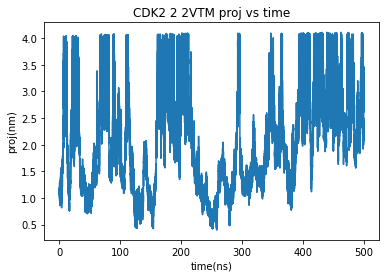

/home/dom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


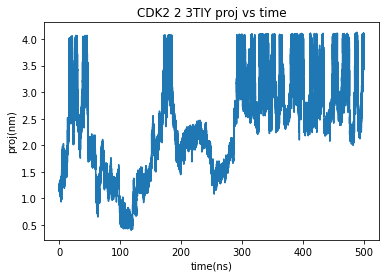

In [24]:
system = 'BRD4'
fragment_pdb_list = ['3U5L','4HBV','4LR6','4MEQ','4PCI','4UYD','3U5J']

for ind in range(0,3):
    cwd = f'{base_dir}/{system}/{ind}_output'
    for pdb_id in fragment_pdb_list:
        cwd = f'{base_dir}/{system}/{ind}_output/{pdb_id}'

        d = {'proj':[], 'ext':[]}
        if os.path.isfile(f'{cwd}/COLVAR.npy'):
            file = np.load(f'{cwd}/COLVAR.npy')
            d['proj'] = file[:,0]
            d['ext'] = file[:,1]

        if d['proj'] != []:
            df = pd.DataFrame(d)

            plt.title(f'{system} {ind} {pdb_id} proj vs time')
            plt.plot(np.linspace(0,df.shape[0]/1000,df.shape[0]),df.proj)
            plt.ylabel('proj(nm)')
            plt.xlabel('time(ns)')
            plt.show()
            
            # if you feel adventurous, plot extent
#             plt.title(f'{system} {ind} {pdb_id} ext vs time')
#             plt.plot(np.linspace(0,df.shape[0]/1000,df.shape[0]),df.ext)
#             plt.ylabel('ext(nm)')
#             plt.xlabel('time(ns)')
#             plt.show()

OpenMM has a bit of a different approach to PLUMED about outputting data from metadynamics simulations. It just writes out the bias deposited across the two CVs at specified intervals, as opposed to 'HILLS' or 'COLVAR' files, with the CV values and the hill heights. In order to have a time plot of dG values, I created  a hack of preserving old 'bias' files, where in between writting a new 'bias' file my code copy-renames the old one from 'bias' to '_bias'. Without this, previous bias file would get overwritten. 

The two functions below deal with how to return the bias files in the correct sequence to plot dG vs time. The third one integrates ext CV, to give a 1D FES.

In [18]:
def find__bias(filename):
    return filename.startswith('_bias')

def find_bias_name_max_n(cwd):
    all_files = os.listdir(cwd)
    bias_files = list(filter(find__bias, all_files))

    # find the prefix, also the largest number
    file_name = ''
    max_n = 0
    for i in bias_files:
        if not file_name:
#             print(i)
            file_name = (i.split('.')[0]).split('_')[1] + '_' + (i.split('.')[0]).split('_')[2]
        number = int((i.split('.')[0]).split('_')[3])
        if number > max_n:
            max_n = number
    
    return file_name, max_n

def integrate_2d_fes(fes, kT = 2.49):

    # Integrates out one of the axes of a FES
    # In this case, we integrate out the 'extent' CV's bias
    
    arr_len = np.shape(fes)[1]
    
    fes_1d = np.zeros(arr_len)
    
    total = 0
    for i in range(arr_len):
        tmp = 0
        for n in fes[:,i]:
            tmp += np.exp(-n/kT)
        fes_1d[i] = -kT*np.log(tmp)
    
    return fes_1d

/home/dom/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/dom/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/dom/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


3U5L
4HBV
4LR6
4MEQ
4PCI
4UYD
3U5J


/home/dom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


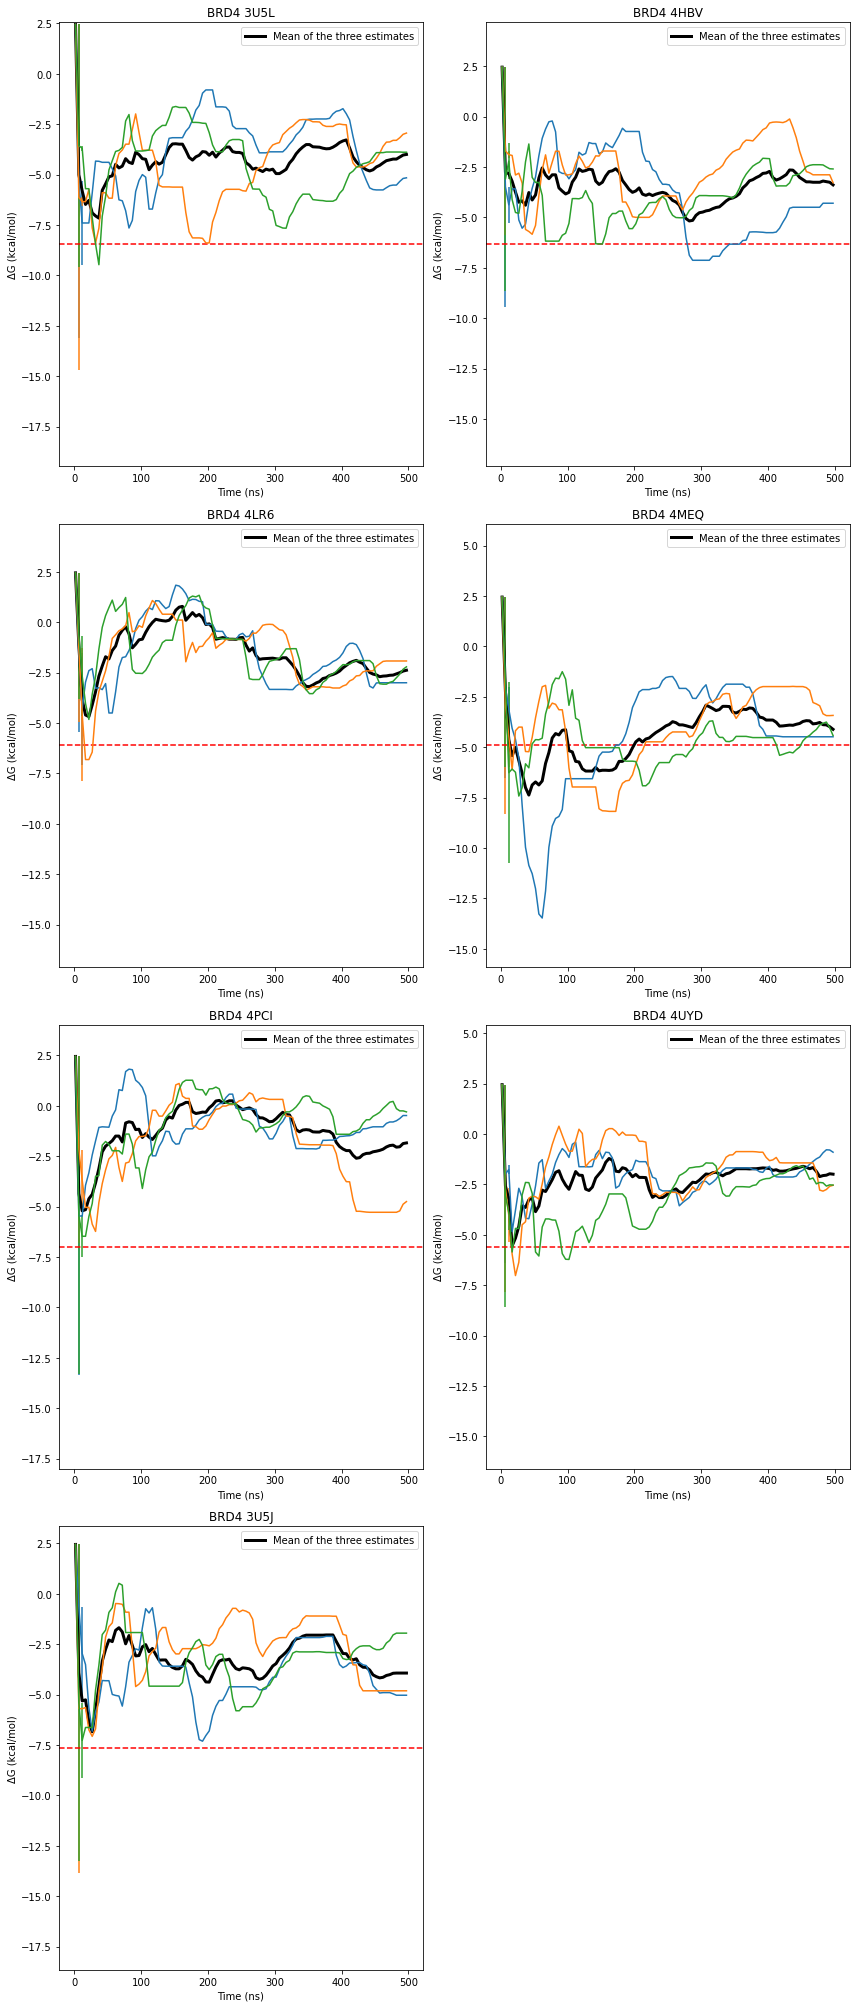

In [19]:
# dG vs time
base_dir = '/home/dom/Projects/openMM-fun-metaD/'
system = 'BRD4'
fragment_pdb_list = ['3U5L','4HBV','4LR6','4MEQ','4PCI','4UYD','3U5J']
funnel_correction = 2.45
plot_index = 1
f = plt.figure(figsize=(12,len(fragment_pdb_list)*4))

for pdb_id in fragment_pdb_list:
    ax = f.add_subplot(int(len(fragment_pdb_list)/2)+1, 2, plot_index)
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('ΔG (kcal/mol)')
    ax.axhline(y = exp_dict[pdb_id], color = 'red', linestyle = '--')

    estimates_lists = deque()

    for ind in range(0,3):

        cwd = f'{base_dir}/{system}/{ind}_output/{pdb_id}'

        os.chdir(cwd)

        ns = []
        estimates = []
        oscillations = []
        start_from_idx = 5

        file_name, max_n = find_bias_name_max_n('.')

        for n in range(1,max_n+1,5):

            if not os.path.isfile(f'{cwd}/_{file_name}_{n}.npy'):
                continue

            raw_fes = np.load(f'{cwd}/_{file_name}_{n}.npy')

            fes = -(raw_fes - np.amax(raw_fes))

            fes_1d = integrate_2d_fes(fes)/4.2
            fes_1d -= np.amin(fes_1d)

            estimate = -(np.median(fes_1d[-40:-20]) - funnel_correction)

            ns.append((n + 1)*1) # recorded every ns
            estimates.append(estimate.round(2))

            # add oscillations
            if n < start_from_idx:
                oscillations.append(0)
            else:
                if n < 10:
                    oscillation = scipy.stats.sem(estimates[:])
                else:
                    oscillation = scipy.stats.sem(estimates[n-10:])
                # 2x as it is the difference between two estimates, bound and unbound
                oscillations.append(oscillation*2) 

        plt.errorbar(ns, estimates, yerr=oscillations)#, color='darkorange', ecolor = 'orange')

        estimates_lists.append(estimates)


    mean_estimates = []

    shortest_list = min([ len(item) for item in estimates_lists])

    for index in range(shortest_list):
        tmp_list = []
        for l in range(len(estimates_lists)):
            tmp_list.append(estimates_lists[l][index])
        mean_estimates.append(np.mean(tmp_list).round(2))

    plt.plot(ns[:len(mean_estimates)], mean_estimates, color = 'black', linewidth = 3,\
             label = 'Mean of the three estimates')
    plt.ylim(exp_dict[pdb_id] - 11, exp_dict[pdb_id] + 11)
    plt.legend()
    plt.title('%s %s'% (system, pdb_id))

    plot_index += 1

    print(pdb_id)

#         plt.savefig('osc_ff14sb_%s_dG_vs_time.png'%pdb_id, dpi = 400)
#         save_dir = '.'
#         plt.savefig('%s/osc_disp_%s_dG_vs_time.png'% (save_dir, system), dpi = 200)

f.tight_layout()
f.show()

-5.08
-2.79
-3.89
3U5L dG = -3.92 kcal/mol +- 0.94, error 4.53 kcal

-4.30
-3.46
-2.60
4HBV dG = -3.45 kcal/mol +- 0.70, error 2.88 kcal

-3.00
-2.35
-2.21
4LR6 dG = -2.52 kcal/mol +- 0.34, error 3.59 kcal

-4.48
-3.23
-4.48
4MEQ dG = -4.07 kcal/mol +- 0.59, error 0.84 kcal

-0.89
-4.46
-1.14
4PCI dG = -2.16 kcal/mol +- 1.62, error 4.83 kcal

-0.90
-2.46
-2.54
4UYD dG = -1.97 kcal/mol +- 0.75, error 3.62 kcal

-4.85
-4.81
-1.96
3U5J dG = -3.88 kcal/mol +- 1.36, error 3.77 kcal


y=0.176213x+-1.979425



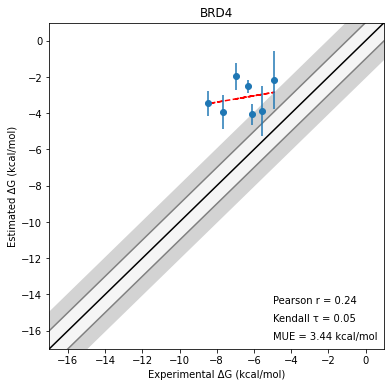

In [22]:
# expt vs estimated

########################
## plotting functions ###
########################

def draw_expt_calc_plot(system, start, end):
    
    if system == 'BRD4':
        fragment_pdb_list = ['3U5L','4HBV','4LR6','4MEQ','4PCI','4UYD','3U5J']
        funnel_correction = 2.45

    base_dir = '/home/dom/Projects/openMM-fun-metaD/'

    exp_dict = {'3U5J': -7.65, '3U5L': -8.45, '4HBV': -6.33, '4LR6': -6.11, '4MEQ': -4.91, '4PCI': -6.99,
                '4UYD': -5.59}

    estimate_dict = {}
    stdiv_list = []
    error_list = []

    for pdb_id in fragment_pdb_list:
        tmp_estimate_list = []
        
        for ind in range(start, end):
            
            cwd = f'{base_dir}/{system}/{ind}_output/{pdb_id}'
            
            file_name, max_n = find_bias_name_max_n(cwd)
            
            raw_fes = np.load(f'{cwd}/{file_name}_{max_n+1}.npy')
            
            fes = -(raw_fes - np.amax(raw_fes))

            fes_1d = integrate_2d_fes(fes)/4.2
            fes_1d -= np.amin(fes_1d)

            estimate = -(np.median(fes_1d[-40:-20]) - funnel_correction)
            
            print('%.2f' % estimate)
            tmp_estimate_list.append(estimate)
        mean_estimate = np.mean(tmp_estimate_list)
        estimate_dict[pdb_id] = mean_estimate

        stdiv = np.std(tmp_estimate_list)
        stdiv_list.append(stdiv)

        error = abs(exp_dict[pdb_id]-mean_estimate)
        error_list.append(error)
        print('%s dG = %.2f kcal/mol +- %.2f, error %.2f kcal\n'%(pdb_id, mean_estimate, stdiv, error))


    exp_list = []
    for k,v in exp_dict.items():
        if k in fragment_pdb_list:
            exp_list.append(v)

    est_list = []
    for k,v in estimate_dict.items():
        est_list.append(v)

    # Lets make a plot now
    
    plt.figure(figsize = (6, 6))
    
    # 2 kcal 'up'
    plt.plot([-26,26],[-24,28],'lightgrey')
    # 1 kcal 'up'
    plt.plot([-26,26],[-25,27],'grey')
    # main trendline y = x
    plt.plot([-26,26],[-26,26],'k-')
    # 1 kcal 'down'
    plt.plot([-26,26],[-27,25],'grey')
    # 2 kcal/down
    plt.plot([-26,26],[-28,24],'lightgrey')

    # light grey for 1 kcal band
    plt.fill_between([-26,26], [-26,26], [-27,25],facecolor='whitesmoke')
    plt.fill_between([-26,26], [-26,26], [-25,27],facecolor='whitesmoke')

    # darker grey for 2 kcal band
    plt.fill_between([-26,26], [-27,25], [-28,24],facecolor='lightgrey')
    plt.fill_between([-26,26], [-25,27], [-24,28],facecolor='lightgrey')


    plt.xlabel('Experimental ΔG (kcal/mol)')
    plt.ylabel('Estimated ΔG (kcal/mol)')

    plt.title('%s'% (system))
    plt.scatter(exp_list, est_list, zorder = 20)
    plt.errorbar(exp_list, est_list, yerr = stdiv_list, linestyle="None", zorder = 15)
    plt.text(-5, -14.5, s = 'Pearson r = %.2f'% scipy.stats.pearsonr(exp_list,est_list)[0])
    plt.text(-5, -15.5, s = 'Kendall τ = %.2f'% scipy.stats.kendalltau(exp_list,est_list)[0])
    plt.text(-5, -16.5, s = 'MUE = %.2f kcal/mol'% np.mean(error_list))

    xmin, xmax = -17, 1
    plt.xlim(xmin, xmax)

    ymin, ymax = -17, 1
    plt.ylim(ymin, ymax)

    # calc the trendline
    z = np.polyfit(exp_list, est_list, 1)
    p = np.poly1d(z)
    plt.plot(exp_list, p(exp_list), "r--")
    
    results_dir = '.'
#     plt.savefig('%s/3x1000ns_%s_results.png'% (results_dir, system), dpi = 400)

    # the line equation:
    print("\ny=%.6fx+%.6f\n"%(z[0],z[1]))


draw_expt_calc_plot('BRD4', 0, 3)

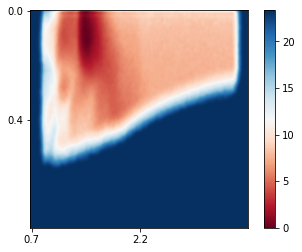

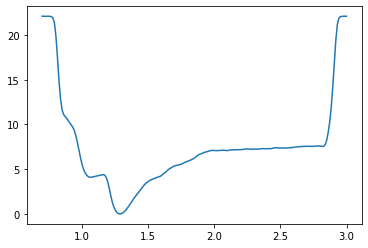

In [26]:
proj_min = 0.7
proj_max = 3.0
ext_min = 0.0
ext_max = 0.8

system = 'BRD4'
ind = 0
pdb_id = '3U5L'

cwd = f'{base_dir}/{system}/{ind}_output/{pdb_id}'
            
file_name, max_n = find_bias_name_max_n(cwd)

raw_fes = np.load(f'{cwd}/{file_name}_{max_n+1}.npy')

fes = -(raw_fes - np.amax(raw_fes)) / 4.2

plt.imshow(fes, cmap='RdBu')

n_step = 100

my_xticks = np.arange(proj_min, proj_max, proj_max/len(np.arange(0,np.shape(fes)[0],n_step)))
plt.xticks(np.arange(proj_min,np.shape(fes)[0],n_step), my_xticks)

my_yticks = np.arange(ext_min, ext_max, ext_max/len(np.arange(0,np.shape(fes)[1],n_step)))
plt.yticks(np.arange(ext_min,np.shape(fes)[1],n_step), my_yticks)

plt.colorbar()
plt.show()

fes = -(raw_fes - np.amax(raw_fes))

fes_1d = integrate_2d_fes(fes)/4.2
fes_1d -= np.amin(fes_1d)

plt.plot(np.linspace(proj_min, proj_max,len(fes_1d)), fes_1d)
plt.show()
plt.show()

In [2]:
# prepare vmd scripts

base_dir = '/home/dom/Projects/openMM-fun-metaD/'

system == 'BRD4'
fragment_pdb_list = ['3U5L','4HBV','4LR6','4MEQ','4PCI','4UYD','3U5J']

for i in range(0,3):

    for pdb_id in fragment_pdb_list:
        os.chdir('%s/%s/%i_output/%s'% (base_dir,system,i,pdb_id))

        with open('vmd_script.tcl','w') as SCRIPT:
            SCRIPT.write('mol load parm7 ../../input/%s/solvatedHMR.prmtop\n'% pdb_id)
            SCRIPT.write('mol modselect 0 0 all not water\n')
            SCRIPT.write('mol modstyle 0 0 NewCartoon\n')
            SCRIPT.write('mol addrep 0\n')
            SCRIPT.write('mol modselect 1 0 resname MOL\n')
            SCRIPT.write('mol modstyle 1 0 Licorice\n')
            SCRIPT.write('mol addrep 0\n')
            SCRIPT.write('mol modselect 2 0 protein within 7 of resname MOL\n')
            SCRIPT.write('mol modstyle 2 0 Lines\n')
            SCRIPT.write('mol addfile trj.dcd step 2\n')